<h1 style="align: center;font-size: 18pt;">Albocycline</h1>

<h2 style="align: center;font-size: 12pt;">About:</h2> 

Albocycline is a macrolactone isolated from Streptomyces maizeus.  This macrolactone has recently been identified as a promising lead antibiotic candidate for the treatment of both vancomycin-resistant S. aureus (VRSA) and MRSA.
    
    

<img title="https://pubchem.ncbi.nlm.nih.gov" src="https://pubchem.ncbi.nlm.nih.gov/image/imagefly.cgi?cid=6440973&width=500&height=500" align="center" height="400" width="400">




<hr style="height:2.5px">

<h2 style="align: center;font-size: 12pt;">Summary:</h2> 

In our previous example we showed in detail how to calculate the consistency of theoretical modeling with experiment. The user gained insight on how to run `biceps` calculations in full. In this example, we will repeat the process will less detail for another system.  In addition, this example will include the code for `multiprocessing` lambda values. Note that 1M steps for tutorial purposes.


**To convert this Jupyter Notebook into a script use the following command:**

```
$ jupyuter nbconvert --to python Albocycline.ipynb
```

<hr style="height:2.5px">

In [1]:
import sys, os, glob, pickle
import numpy as np
import biceps
import multiprocessing as mp

BICePs - Bayesian Inference of Conformational Populations, Version 2.0


In [5]:
####### Data and Output Directories #######
print(f"Possible input data extensions: {biceps.toolbox.list_possible_extensions()}")
top ='albocycline/pdbs/0.pdb'
energies = np.loadtxt('albocycline/albocycline_QMenergies.dat')*627.509  # convert from hartrees to kcal/mol
energies = energies/0.5959   # convert to reduced free energies F = f/kT
energies -= energies.min()  # set ground state to zero, just in case
states = len(energies)
dataFiles = 'albocycline/new_J_NOE'
data = biceps.toolbox.sort_data(dataFiles)
print(f"Input data: {biceps.toolbox.list_extensions(data)}")
outdir = 'results'
biceps.toolbox.mkdir(outdir)

Possible input data extensions: ['H', 'Ca', 'N', 'J', 'noe', 'pf']
Input data: ['J', 'noe']


In [6]:
####### Parameters #######
nsteps=10000000
print(f"nSteps of sampling: {nsteps}")
n_lambdas = 3
lambda_values = np.linspace(0.0, 1.0, n_lambdas)
ref = ['uniform', 'exp']
uncern = [[0.05, 20.0, 1.02], [0.05, 5.0, 1.02]]

nSteps of sampling: 10000000


In [7]:
####### Multiprocessing Lambda values #######
def mp_lambdas(Lambda):
    print(f"lambda: {Lambda}")
    ensemble = biceps.Ensemble(Lambda, energies, top, verbose=False)
    ensemble.initialize_restraints(input_data=data, ref_pot=ref,
            gamma=[0.2, 5.0, 1.01], debug=False)
    sampler = biceps.PosteriorSampler(ensemble.to_list())
    sampler.sample(nsteps=nsteps, verbose=False)
    sampler.traj.process_results(outdir+'/traj_lambda%2.2f.npz'%(Lambda))
    outfilename = 'sampler_lambda%2.2f.pkl'%(Lambda)
    fout = open(os.path.join(outdir, outfilename), 'wb')
    pickle.dump(sampler, fout)
    fout.close()
    print('...Done.')

In [8]:
print("Number of CPU's: %s"%(mp.cpu_count()))
p = mp.Pool(processes=n_lambdas) # knows the number of CPU's to allocate
print(f"Number of processes: {n_lambdas}")
jobs = []
for lam in lambda_values:
    process = p.Process(target=mp_lambdas, args=(lam,))
    jobs.append(process)
    jobs[-1].start() # Start the processes
    active_processors = [jobs[i].is_alive() for i in range(len(jobs))]
    if (len(active_processors) == mp.cpu_count()-1) and all(active_processors) == True:
        #print("Waiting until a processor becomes available...")
        while all(active_processors) == True:
            active_processors = [jobs[i].is_alive() for i in range(len(jobs))]

        inactive = int(np.where(np.array(active_processors) == False)[0])
        jobs[inactive].terminate()
        jobs.remove(jobs[inactive])
for job in jobs:
    job.join() # will wait until the execution is over...
p.close()

Number of CPU's: 6
Number of processes: 3
lambda: 0.0
lambda: 0.5
lambda: 1.0

Accepted 72.14228 % 


Accepted [32.63885 31.71776 31.71776  7.78567] % 


Accepted 71.36804 % 


Accepted [32.63184 31.53664 31.53664  7.19956] % 

...Done.

Accepted 66.93186 % 


Accepted [32.65749 31.69709 31.69709  2.57728] % 

...Done.
...Done.


Loading results/traj_lambda0.00.npz ...
Loading results/traj_lambda0.50.npz ...
Loading results/traj_lambda1.00.npz ...
not all state sampled, these states [ 5  7  9 11 15 16 25 34 40 42 48 77 81 87 95 98] are not sampled
Loading results/sampler_lambda0.00.pkl ...
Loading results/sampler_lambda0.50.pkl ...
Loading results/sampler_lambda1.00.pkl ...
lam = [0.0, 0.5, 1.0]
nstates 100
Writing results/BS.dat...
...Done.
Writing results/populations.dat...
...Done.


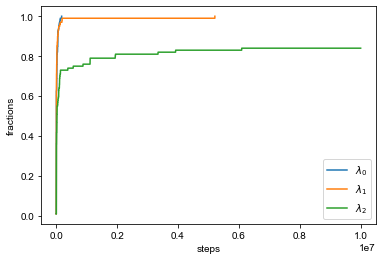

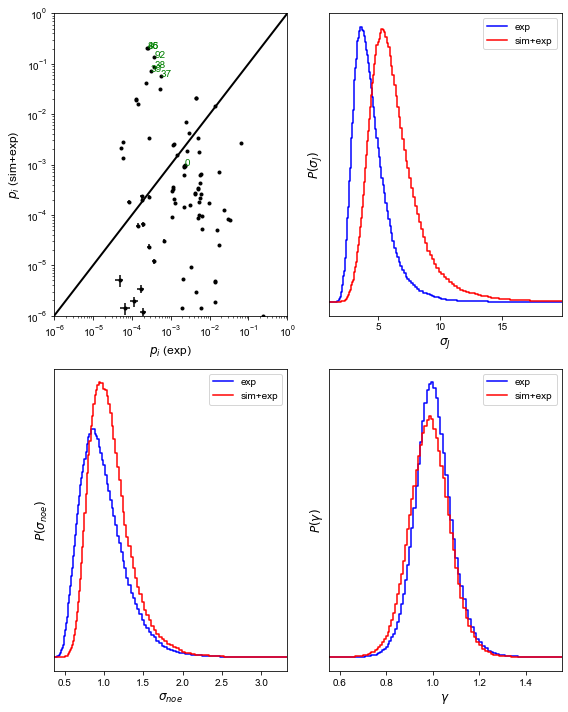

In [9]:
####### Posterior Analysis #######
%matplotlib inline
A = biceps.Analysis(states=states, resultdir=outdir+"/",
    BSdir='BS.dat', popdir='populations.dat',
    picfile='BICePs.pdf')
A.plot()

<h6 style="align: justify;font-size: 12pt"># <span style="color:red;">NOTE</span>: The following cell is for pretty notebook rendering</h6>

In [7]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../../theme.css", "r").read()
    return HTML(styles)
css_styling()